In [96]:
!pip install mediapipe scipy

In [3]:
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade tensorflow
!pip install --upgrade mediapipe opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 56.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.21 requires numpy<2, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
yfinance 0.2.59 requires protobuf<6,>=5.29.0, but you have protobuf 4.25.7 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.7 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.19.0 which is incompatible.
yfinance 0.2.59 requires protobuf<6,>=5.29.0, but you have protobuf 4.25.7 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have num

In [ ]:
#!pip install numpy==1.24.4 protobuf==3.20.3 thinc==8.1.0 grpcio-status==1.54.0 ydf==0.9.0

#!pip install mediapipe thinc grpcio-status ydf sounddevice

In [ ]:
!pip install mediapipe --upgrade --quiet

In [84]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from google.colab import files
from google.colab.patches import cv2_imshow
import pandas as pd
from scipy.signal import butter, filtfilt

In [4]:
# === Upload video and calibration image ===
print("Upload your gait video:")
video_file = files.upload()
video_path = list(video_file.keys())[0]

Upload your gait video:


Saving gait_01.mov to gait_01.mov


In [6]:
print("Upload your calibration image:")
calib_file = files.upload()
calib_image_path = list(calib_file.keys())[0]

Upload your calibration image:


Saving Calibration.png to Calibration.png


In [153]:
# === Calibration ===
img = cv2.imread(calib_image_path)
#cv2_imshow(img)

print("Choose calibration method:")
print("1 - Click two points")
print("2 - Enter coordinates manually")
method = input("Enter 1 or 2: ").strip()

if method == '1':
    print("Click two points with known real-world distance. Press ESC when done.")
    pts = []
    def click_event(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            pts.append((x, y))
            cv2.circle(img, (x, y), 5, (255, 0, 0), -1)
            cv2.imshow("Calibration", img)

    cv2.imshow("Calibration", img)
    cv2.setMouseCallback("Calibration", click_event)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    x1 = float(input("Enter x-coordinate of point 1: "))
    y1 = float(input("Enter y-coordinate of point 1: "))
    x2 = float(input("Enter x-coordinate of point 2: "))
    y2 = float(input("Enter y-coordinate of point 2: "))
    pts = [(x1, y1), (x2, y2)]

Choose calibration method:
1 - Click two points
2 - Enter coordinates manually
Enter 1 or 2: 2
Enter x-coordinate of point 1: 214
Enter y-coordinate of point 1: 1528
Enter x-coordinate of point 2: 628.9
Enter y-coordinate of point 2: 1647.9
Enter the real-world distance between points in meters: 0.77


In [180]:
# --- Robust calibration: check for zero or tiny pixel distance ---
pixel_distance = np.linalg.norm(np.array(pts[0]) - np.array(pts[1]))
min_pixel_dist = 0.3 * max(img_w, img_h)  # Require at least 30% of image dimension
if pixel_distance < min_pixel_dist:
    raise ValueError(f"Calibration pixel distance ({pixel_distance:.2f}) is too small. "
                     f"Please select points further apart (at least {min_pixel_dist:.0f} pixels).")

KNOWN_DISTANCE_M = float(input("Enter the real-world distance between points in meters: "))
pixel_to_meter = KNOWN_DISTANCE_M / pixel_distance
print(f"Pixel distance: {pixel_distance:.2f} pixels, Calibration factor: {pixel_to_meter:.6f} m/pixel")

if pixel_to_meter < 0.0001 or pixel_to_meter > 0.05:
    print("\n[WARNING] Calibration factor is outside typical range (0.0002–0.005 m/pixel).")
    print("Check calibration points and known distance. Re-run calibration if needed.")

Enter the real-world distance between points in meters: 0.77
Pixel distance: 431.88 pixels, Calibration factor: 0.001783 m/pixel


In [154]:
print(pixel_to_meter)

0.0017829137196429807


In [167]:
# === MediaPipe Pose Init ===
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.8, min_tracking_confidence=0.5) # Confidence parameters
mp_drawing = mp.solutions.drawing_utils

In [168]:
# === Open video ===
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)

LEFT_HEEL = 29
RIGHT_HEEL = 30

heel_data = {'Left': [], 'Right': []}
timestamps = []

In [193]:
# === Process video and collect heel data ===
# Initialize the pose estimator here
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    t_us = cap.get(cv2.CAP_PROP_POS_MSEC) * 1000
    img_h, img_w = frame.shape[:2]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb)

    # Check if pose landmarks are detected before accessing them
    if results.pose_landmarks:
        lms = results.pose_landmarks.landmark
        # Convert normalized coords to pixel coords for both feet
        for foot, idx in [('Left', LEFT_HEEL), ('Right', RIGHT_HEEL)]:
            # Get the landmark if it exists, otherwise skip
            try:
                norm_x = lms[idx].x
                norm_y = lms[idx].y
                pixel_x = norm_x * img_w
                pixel_y = norm_y * img_h

                # Append the data to heel_data if landmarks are detected
                heel_data[foot].append((t_us/1e6, pixel_x, pixel_y))
            except IndexError:
                # Handle the case where the landmark is not detected
                print(f"Landmark {idx} not detected in this frame. Skipping.")
                continue # Skip to the next foot
    timestamps.append(t_us/1e6)

cap.release()

In [194]:
# === Low-pass filter for smoothing ===
def butter_lowpass_filter(data, cutoff, fs, order=2):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

fs = fps
cutoff = 3.0  # You can prompt user to adjust if needed

for foot in ['Left', 'Right']:
    arr = np.array(heel_data[foot])
    if len(arr) == 0:
        continue
    t = arr[:,0]
    x = arr[:,1]
    y = arr[:,2]
    x_filt = butter_lowpass_filter(x, cutoff, fs)
    y_filt = butter_lowpass_filter(y, cutoff, fs)
    heel_data[foot] = np.column_stack([t, x_filt, y_filt])

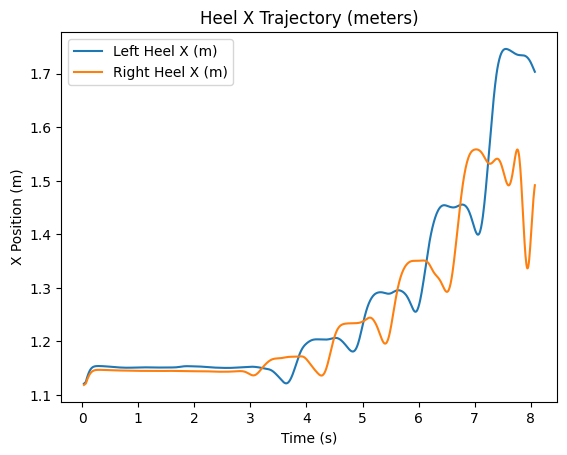

In [198]:
# === Plotting heel trajectories for debugging ===
for foot in ['Left', 'Right']:
    arr = heel_data[foot]
    if len(arr) > 0:
        plt.plot(arr[:,0], arr[:,1]*pixel_to_meter, label=f'{foot} Heel X (m)')
plt.title('Heel X Trajectory (meters)')
plt.xlabel('Time (s)')
plt.ylabel('X Position (m)')
plt.legend()
plt.show()

In [196]:
# === Event detection (HS/TO) using y minima/maxima with larger window ===
events = []
window = 5
def is_local_min(y, i, w):
    return all(y[i] < y[j] for j in range(max(0,i-w), min(len(y),i+w+1)) if j != i)
def is_local_max(y, i, w):
    return all(y[i] > y[j] for j in range(max(0,i-w), min(len(y),i+w+1)) if j != i)

for foot in ['Left', 'Right']:
    arr = heel_data[foot]
    if len(arr) < window:
        continue
    t = arr[:,0]
    y = arr[:,2]
    for i in range(window, len(y)-window):
        if is_local_min(y, i, window):
            events.append({'event': 'HS', 'foot': foot, 't': t[i], 'x': arr[i,1], 'y': arr[i,2]})
        if is_local_max(y, i, window):
            events.append({'event': 'TO', 'foot': foot, 't': t[i], 'x': arr[i,1], 'y': arr[i,2]})

df = pd.DataFrame(events)
metrics = {}

In [200]:
# === Metric Extraction ===

# Cycle Time
for foot in ['Left', 'Right']:
    hs_times = df[(df.foot == foot) & (df.event == 'HS')]['t'].values
    if len(hs_times) >= 2:
        cycle_times = np.diff(hs_times)
        metrics[f'Cycle Time ({foot})'] = np.mean(cycle_times)

# Step Length using nearest-opposite HS
step_lengths = []
for index, row in df[df.event == 'HS'].iterrows():
    opposite_foot = 'Left' if row.foot == 'Right' else 'Right'
    opp_hs = df[(df.foot == opposite_foot) & (df.event == 'HS')]
    if len(opp_hs) == 0:
        continue
    time_diffs = np.abs(opp_hs['t'].values - row['t'])
    nearest_idx = np.argmin(time_diffs)
    nearest = opp_hs.iloc[nearest_idx]
    dist_pix = np.sqrt((row.x - nearest.x)**2 + (row.y - nearest.y)**2)
    dist_m = dist_pix * pixel_to_meter
    step_lengths.append(dist_m)

if step_lengths:
    metrics['Average Step Length (m)'] = np.mean(step_lengths)

# Stride Length
stride_lengths = []
for foot in ['Left', 'Right']:
    hs_foot = df[(df.foot == foot) & (df.event == 'HS')]
    for i in range(len(hs_foot) - 1):
        x1, y1 = hs_foot.iloc[i][['x', 'y']]
        x2, y2 = hs_foot.iloc[i+1][['x', 'y']]
        dist_pix = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        dist_m = dist_pix * pixel_to_meter
        stride_lengths.append(dist_m)

if stride_lengths:
    metrics['Average Stride Length (m)'] = np.mean(stride_lengths)

# Gait Speed
if metrics.get('Average Stride Length (m)', 0) > 0 and metrics.get('Cycle Time (Left)', 0) > 0:
    metrics['Gait Speed (m/s)'] = metrics['Average Stride Length (m)'] / metrics['Cycle Time (Left)']

# Stance Time
for foot in ['Left', 'Right']:
    to_times = df[(df.foot == foot) & (df.event == 'TO')]['t'].values
    hs_times = df[(df.foot == foot) & (df.event == 'HS')]['t'].values
    stance_times = []
    for to in to_times:
        next_hs = hs_times[hs_times > to]
        if len(next_hs) > 0:
            stance_times.append(next_hs[0] - to)
    if stance_times:
        metrics[f'Stance Time ({foot})'] = np.mean(stance_times)

# Double Support Time
ds_times = []
for i in range(1, len(df)):
    e1, e2 = df.iloc[i-1], df.iloc[i]
    if e1.event == 'TO' and e2.event == 'HS' and e1.foot != e2.foot:
        ds_times.append(e2.t - e1.t)
if ds_times:
    metrics['Average Double Support Time (s)'] = np.mean(ds_times)

# Step Width
widths = []
for index, row in df[df.event == 'HS'].iterrows():
    opposite_foot = 'Left' if row.foot == 'Right' else 'Right'
    opp_hs = df[(df.foot == opposite_foot) & (df.event == 'HS')]
    if len(opp_hs) == 0:
        continue
    time_diffs = np.abs(opp_hs['t'].values - row['t'])
    nearest_idx = np.argmin(time_diffs)
    nearest = opp_hs.iloc[nearest_idx]
    width = abs(row.x - nearest.x) * pixel_to_meter
    widths.append(width)
if widths:
    metrics['Average Step Width (m)'] = np.mean(widths)

if df.empty:
    print("\nNo gait events detected. Please review the video, calibration, and event detection settings.")
else:
    print("\n=== Gait Metrics ===")
    for k, v in metrics.items():
        print(f"{k}: {v:.3f}")

# Diagnostic print
if pixel_to_meter < 0.0001 or pixel_to_meter > 0.05:
    print("\n[WARNING] Calibration factor is outside typical range. Please check your calibration points and known distance.")
    print("Typical values: 0.0002–0.005 m/pixel (depends on camera and setup).")
    print("If this warning appears, re-run calibration and select points further apart or verify your known distance.")



=== Gait Metrics ===
Cycle Time (Left): 0.635
Cycle Time (Right): 0.651
Average Step Length (m): 0.146
Average Stride Length (m): 0.115
Gait Speed (m/s): 0.181
Stance Time (Left): 0.236
Stance Time (Right): 0.227
Average Step Width (m): 0.087
